# Report for Isaac Physics

Here is the source code for generating the key conclusions from a statistical analysis of IP. 
The following is included:

* Loading, joining and preparing a subset of the data.
* Creating proxies for IP activity such as 
    * Immersion (ratio of students on platform over students taking Physics exams in 2016)
    * Performance (ratio of correct question attempts for each student taking Physics exams in 2016)
* Determining active and inactive groups according to certain thresholds of activity proxies.
* Determining difference in exam results between active and inactive groups.

## Loading and arranging data

Here we load external and clickstream data, join them and then choose a suitable subset. 

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.feature_selection import f_classif
#from helper_files import checkLinearFit, test_correlation, sensitivity_on_bin_ANOVA, sensitivity_on_bin_scipy
#from stats_helper_files import *
import stats_helper_files as stat

# Inputs
external_csv = r"/home/andris/GitHub/data/school_ext_data.csv"
internal_csv = r"/home/andris/GitHub/data/school_clk_data.csv"

In [87]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)
print('Total number of schools in external spreadsheet:',len(df_ext))

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)
print('Total number of schools in internal spreadsheet:',len(df_int))

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))
print('Number of schools after joining:',len(df))

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]
print('Number of schools that had all science courses:',len(df))

# Remove schools that have any outliers
#df = df[df['Outlier?']==0]
#print('Number of schools with no outliers:',len(df))

df.head(5)

Total number of schools in external spreadsheet: 2776
Total number of schools in internal spreadsheet: 1238
Number of schools after joining: 2776
Number of schools that had all science courses: 899


,Entries|2013_Biology,Entries|2013_Chemistry,Entries|2013_Mathematics,Entries|2013_Physics,Entries|2014_Biology,Entries|2014_Chemistry,Entries|2014_Mathematics,Entries|2014_Physics,Entries|2015_Biology,Entries|2015_Chemistry,...,q_lvl_3_cor_std,q_lvl_4_std,q_lvl_4_cor_std,q_lvl_5_std,q_lvl_5_cor_std,q_lvl_6_std,q_lvl_6_cor_std,view_concept_std,view_hint_std,Outlier?
URN,,,,,,,,,,,,,,,,,,,,,
100001,19.0,25.0,53.0,17.0,16.0,20.0,41.0,17.0,15.0,14.0,...,88.0,78.0,32.0,9.0,9.0,0.0,0.0,26.0,463.0,0.0
100003,24.0,35.0,77.0,41.0,39.0,37.0,88.0,34.0,26.0,45.0,...,34.0,0.0,0.0,0.0,0.0,0.0,1.0,31.0,628.0,1.0
100054,32.0,21.0,75.0,29.0,34.0,35.0,69.0,21.0,42.0,28.0,...,167.0,201.0,44.0,128.0,50.0,0.0,0.0,25.0,2158.0,1.0
100065,33.0,35.0,70.0,28.0,30.0,34.0,67.0,31.0,25.0,29.0,...,30.0,387.0,106.0,189.0,26.0,24.0,1.0,41.0,1946.0,1.0
100076,10.0,14.0,27.0,11.0,18.0,21.0,32.0,12.0,22.0,20.0,...,0.0,3.0,7.0,2.0,2.0,0.0,0.0,1.0,5.0,0.0


## Choosing activity proxies

Here we choose some proxies for IP activity. 
Further to this, we the improvement in exam score as 

```
exam_improv_year_1-year_2 = (exam_score_year_1 - exam_score_2) - <(exam_score_year_1 - exam_score_2)>
```

This represents improvement in exam score relative to the mean for those years. 

An alternative way of correcting for grade inflation would be to define it as follows

```
exam_improv_year_1-year_2 = (exam_score_year_1 - exam_score_2)/ <(exam_score_year_1 - exam_score_2)>
```

The approach can be chosen bythe user

In [88]:
# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

# Defining it relative to the mean

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Student activity
df['std_q_cor'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_ratio'] =  (df['user_id_std']/df['Entries|2016_Physics']).fillna(0) 

# Trying a combination
df['combo'] = (df['std_q_cor']/df['std_q_cor'].mean()) + (df['std_ratio']/df['std_ratio'].mean())

In [89]:
# ------------------------------------------------------
# Dropping uneeded features
# ------------------------------------------------------

# Remove unneeded clickstream data
df = df.drop(df.filter(regex='_tch|_std').columns,axis=1)
df = df.drop(['view_assig_prog','add_custom_assig','add_assig','create_group','add_user'],axis=1)

# Set all external indices with no value as NULL
df['IDACI'] = df['IDACI'].replace(to_replace=0,value=np.nan)
df['L_M_index'] = df['L_M_index'].replace(to_replace=0,value=np.nan)
df['Effectiveness'] = df['Effectiveness'].replace(to_replace=0,value=np.nan)
df['Teach_quality'] = df['Teach_quality'].replace(to_replace=0,value=np.nan)

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

## Seperating into active and inactive groups

Here we bin into different groups according to a prescribed threshold of IP activity. 

We have 2 proxies for determing IP activity:

* Performance
* Immersion

First it would be interesting to see how the distribution of schools changes according to these proxies. 
Then we can plot histograms to check out how the active and inactive users may differ. 


In [90]:
# Number of inactive schools

print('Schools with zero immersion:',df[df['std_ratio']==0]['std_ratio'].count())
print('Schools with zero performance:',df[df['std_q_cor']==0]['std_ratio'].count())

Schools with zero immersion: 400
Schools with zero performance: 410


Text(0,0.5,'Number of active schools')

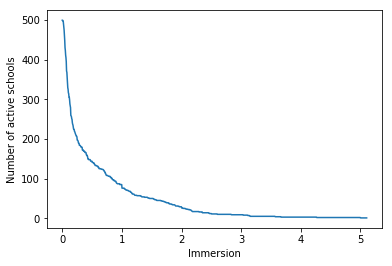

In [91]:
store = [];

for item in range(1000)*max(df['std_ratio'])/1000:                           
    store.append(df[df['std_ratio'] > item]['std_ratio'].count())
    
plt.plot(range(1000)*max(df['std_ratio'])/1000,store)
plt.xlabel('Immersion')
plt.ylabel('Number of active schools')

Text(0,0.5,'Number of active schools')

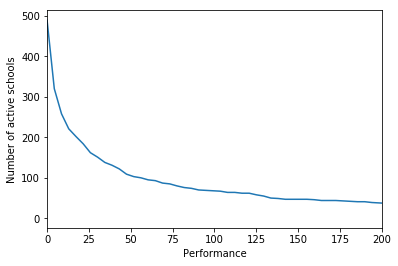

In [92]:
store = [];

for item in range(1000)*max(df['std_q_cor'])/1000:                           
    store.append(df[df['std_q_cor'] > item]['std_q_cor'].count())
    
plt.plot(range(1000)*max(df['std_q_cor'])/1000,store)
plt.xlim([0,200])
plt.xlabel('Performance')
plt.ylabel('Number of active schools')

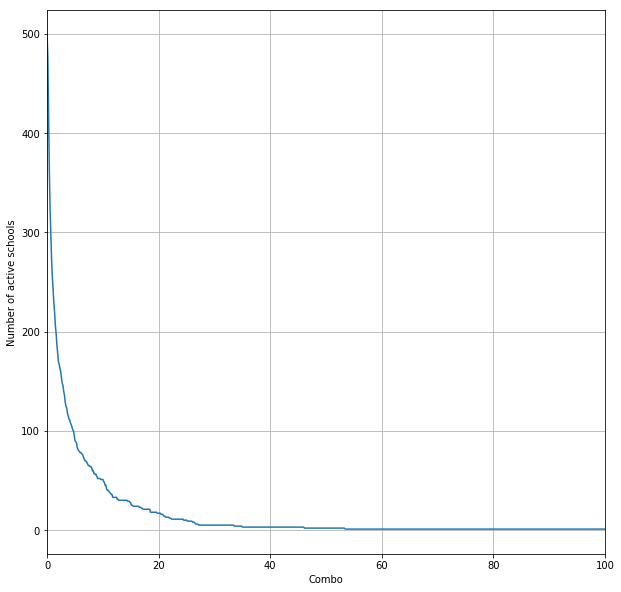

In [105]:
store = [];

for item in range(1000)*max(df['combo'])/1000:                           
    store.append(df[df['combo'] > item]['combo'].count())
    
plt.figure(figsize=(10,10))
plt.plot(range(1000)*max(df['combo'])/1000,store)
plt.xlim([0,100])
plt.xlabel('Combo')
plt.ylabel('Number of active schools')
plt.grid()

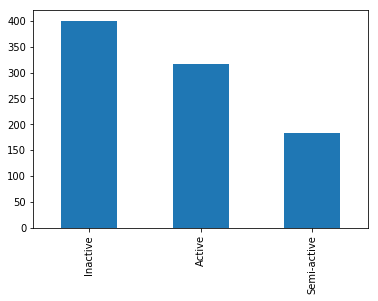

In [94]:
# ------------------------------------------------------
# Binning and displaying the distribution
# ------------------------------------------------------

bins = [-0.1, 0, 0.1,10000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = stat.bin_groups(df,'std_ratio',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')
plt.savefig('distribution.png', format='png', dpi=300)

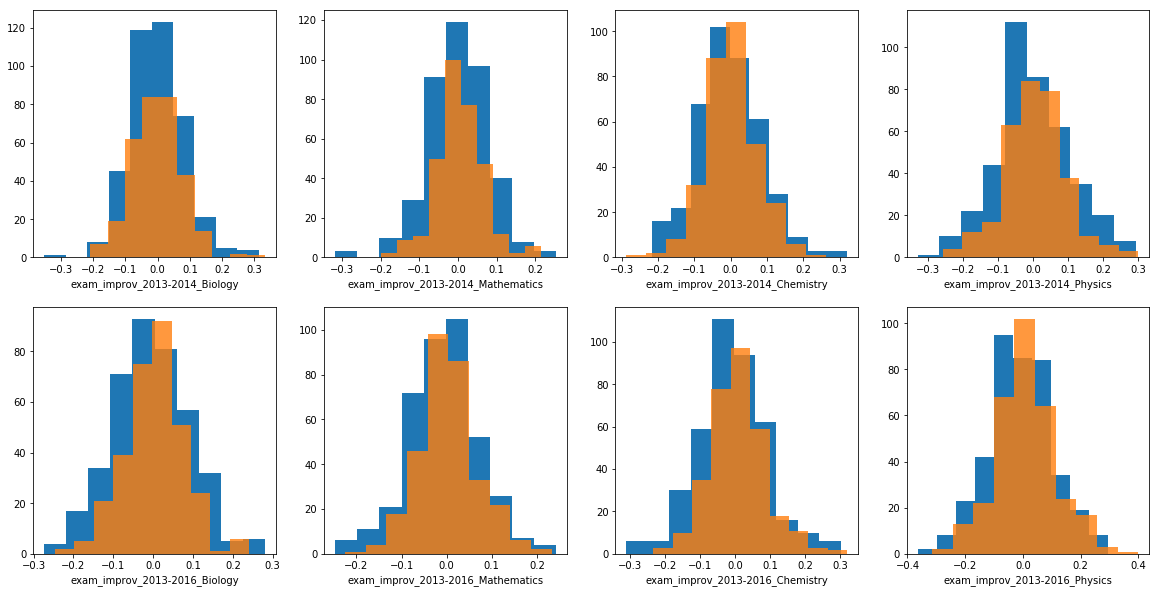

In [95]:
# Checking for distribution of exam imrovement
stat.plotHistograms(df, df.filter(regex='exam_improv').columns,2,4)

## Checking for significant differences

Now that we have subdivided the 2 groups, we can check any differences that they may have in exam results.

In [96]:
print('Doing an ANOVA F-test')

df_test = df[df['categories']!= 'Semi-active']

X = df_test.filter(regex='exam_improv')
y = [1 if item == 'Active' else 0 for item in df_test['categories']]
F, pval = f_classif(X, y)

df_score = pd.DataFrame({'Key':X.keys(),'F score':F,'p values':pval})

df_score.sort_values('p values')

Doing an ANOVA F-test


,F score,Key,p values
7,5.397046,exam_improv_2013-2016_Physics,0.020451
6,4.934415,exam_improv_2013-2016_Chemistry,0.026640
5,3.866692,exam_improv_2013-2016_Mathematics,0.049640
4,1.917056,exam_improv_2013-2016_Biology,0.166614
1,1.354593,exam_improv_2013-2014_Mathematics,0.244866
3,1.333153,exam_improv_2013-2014_Physics,0.248631
2,0.464922,exam_improv_2013-2014_Chemistry,0.495554
0,0.017323,exam_improv_2013-2014_Biology,0.895325


In [97]:
print('Using Kolmogorov-Smirnov test')

stat.non_parametric_test(df, df.filter(regex='exam_improv').columns, ks_2samp)


Using Kolmogorov-Smirnov test


,Feature,P val,Score
4,exam_improv_2013-2016_Biology,0.002360,0.136867
3,exam_improv_2013-2014_Physics,0.008750,0.122848
6,exam_improv_2013-2016_Chemistry,0.008849,0.122722
7,exam_improv_2013-2016_Physics,0.020125,0.113038
2,exam_improv_2013-2014_Chemistry,0.034015,0.106392
5,exam_improv_2013-2016_Mathematics,0.034429,0.106234
1,exam_improv_2013-2014_Mathematics,0.046763,0.102152
0,exam_improv_2013-2014_Biology,0.909722,0.041930


In [98]:
print('Using Mann-Whitney U test')

stat.non_parametric_test(df, df.filter(regex='exam_improv').columns, mannwhitneyu)


Using Mann-Whitney U test


,Feature,P val,Score
6,exam_improv_2013-2016_Chemistry,0.010691,56875.5
7,exam_improv_2013-2016_Physics,0.014242,57179.5
5,exam_improv_2013-2016_Mathematics,0.048437,58637.0
3,exam_improv_2013-2014_Physics,0.052754,58751.0
4,exam_improv_2013-2016_Biology,0.054399,58792.5
1,exam_improv_2013-2014_Mathematics,0.137336,60197.5
2,exam_improv_2013-2014_Chemistry,0.154177,60400.0
0,exam_improv_2013-2014_Biology,0.439482,62781.0


## Sensitivity analysis

We are interested in the difference between the 2 groups and the effect that the cut off value has on this. 

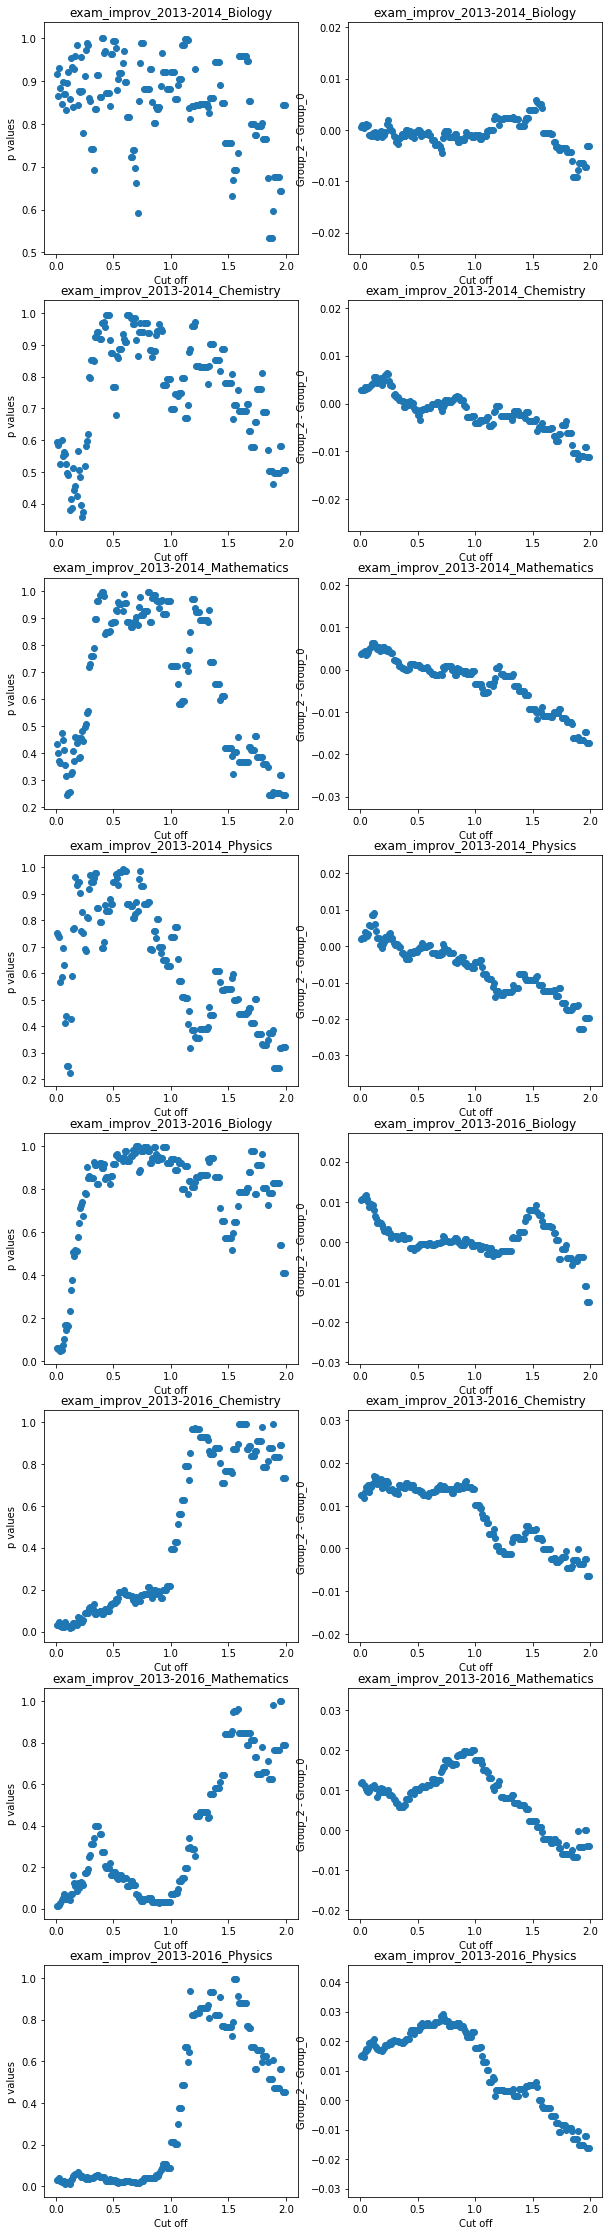

In [99]:
# Checking immersion with an ANOVA test

bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,200))*0.01
df_score = stat.sensitivity_on_bin(df, 'std_ratio', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], 
                                   cut_off_array, test_type='ANOVA')

stat.plot_sensitivity(df_score,np.unique(df_score['Key']),['p values', 'Group_2 - Group_0'])

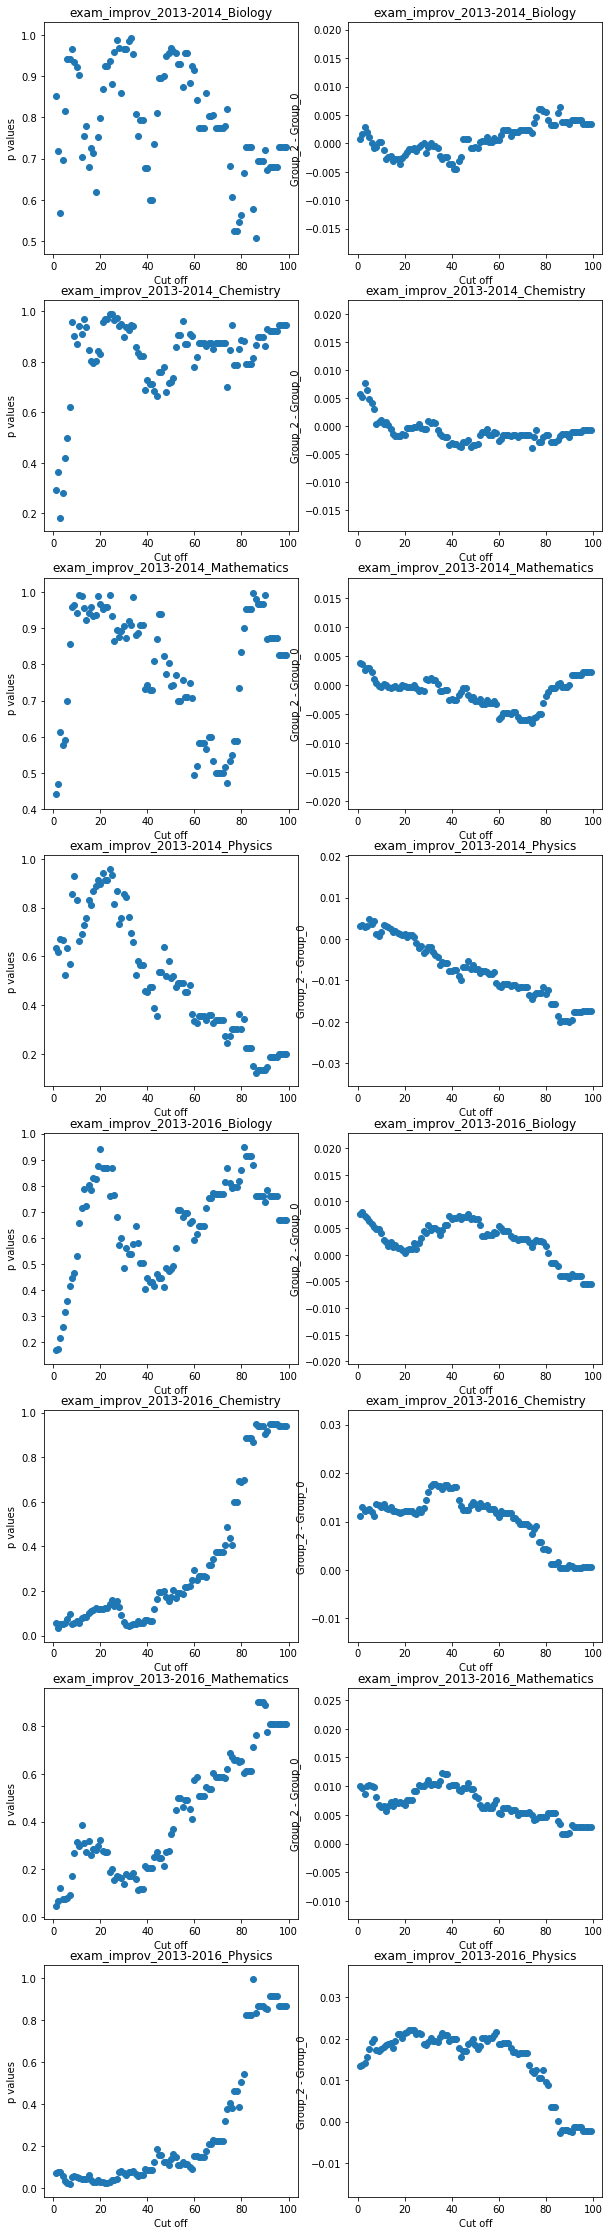

In [100]:
# Checking performance with an ANOVA test

bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,100))*1
df_score = stat.sensitivity_on_bin(df, 'std_q_cor', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], 
                                   cut_off_array, test_type='ANOVA')

stat.plot_sensitivity(df_score,np.unique(df_score['Key']),['p values', 'Group_2 - Group_0'])

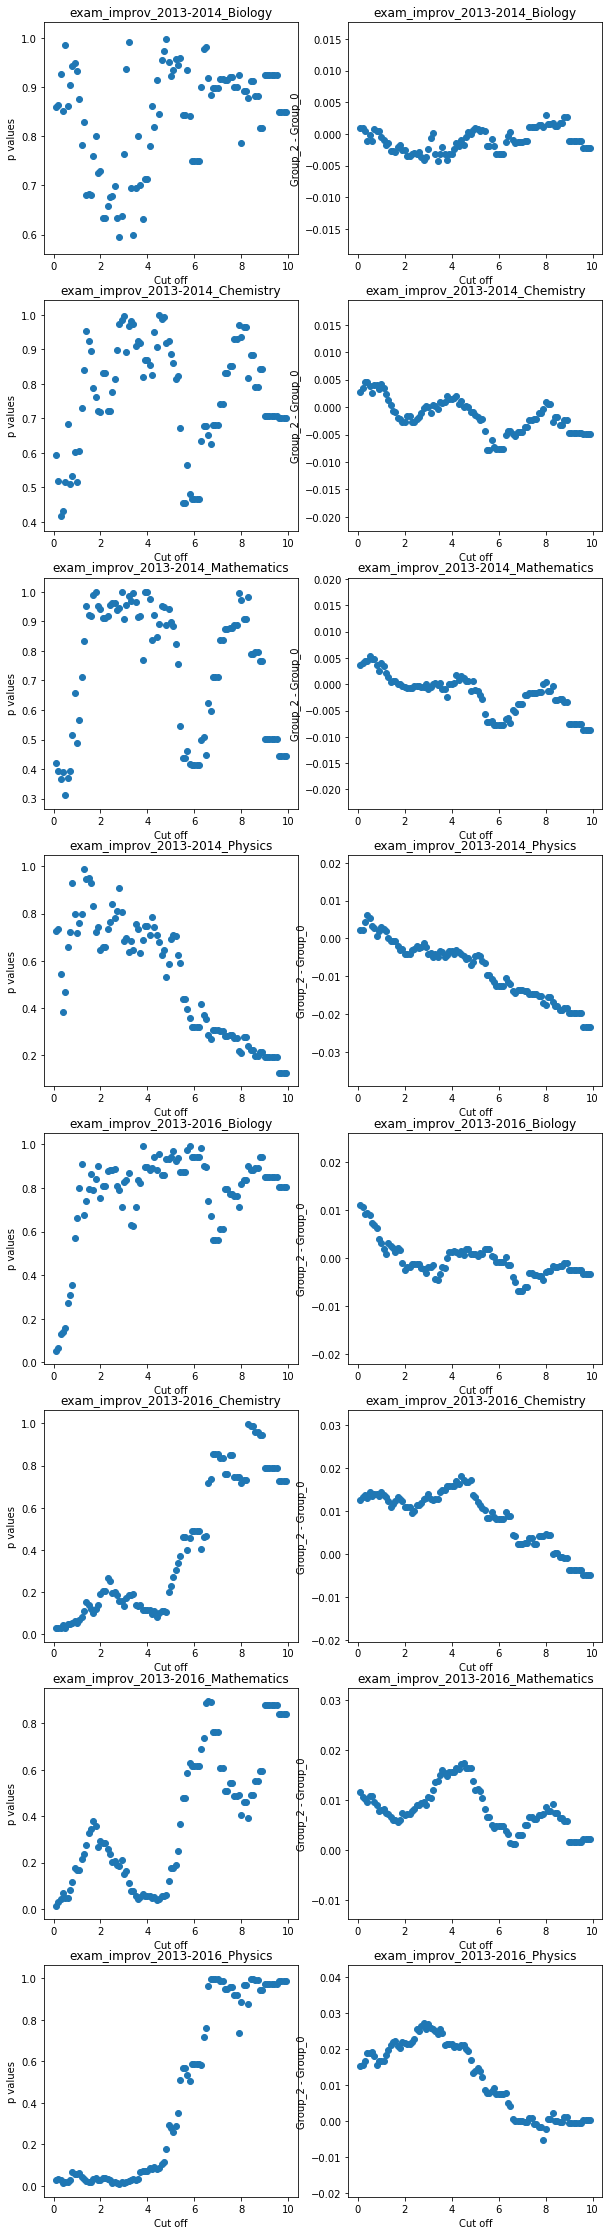

In [104]:
# Doing an ANOVA test on Combo

bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,100))*0.1
df_score = stat.sensitivity_on_bin(df, 'combo', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], 
                                   cut_off_array, test_type='ANOVA')

stat.plot_sensitivity(df_score,np.unique(df_score['Key']),['p values', 'Group_2 - Group_0'])

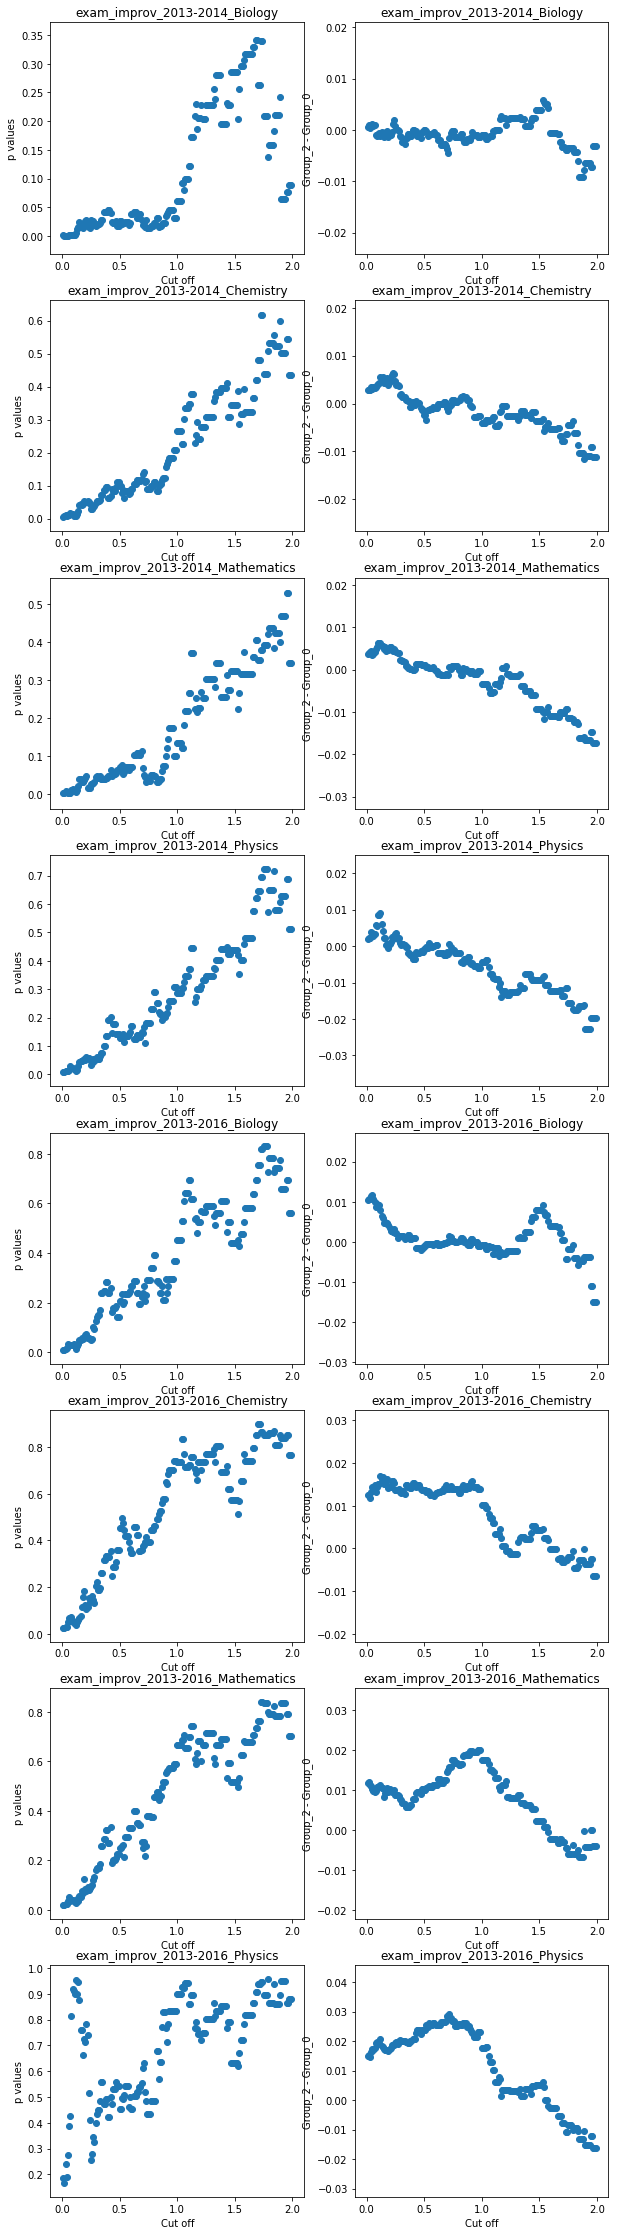

In [102]:
# With a KS test

bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,200))*0.01
df_score = stat.sensitivity_on_bin(df, 'std_ratio', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], 
                                   cut_off_array, test_type=ks_2samp)

stat.plot_sensitivity(df_score,np.unique(df_score['Key']),['p values', 'Group_2 - Group_0'])

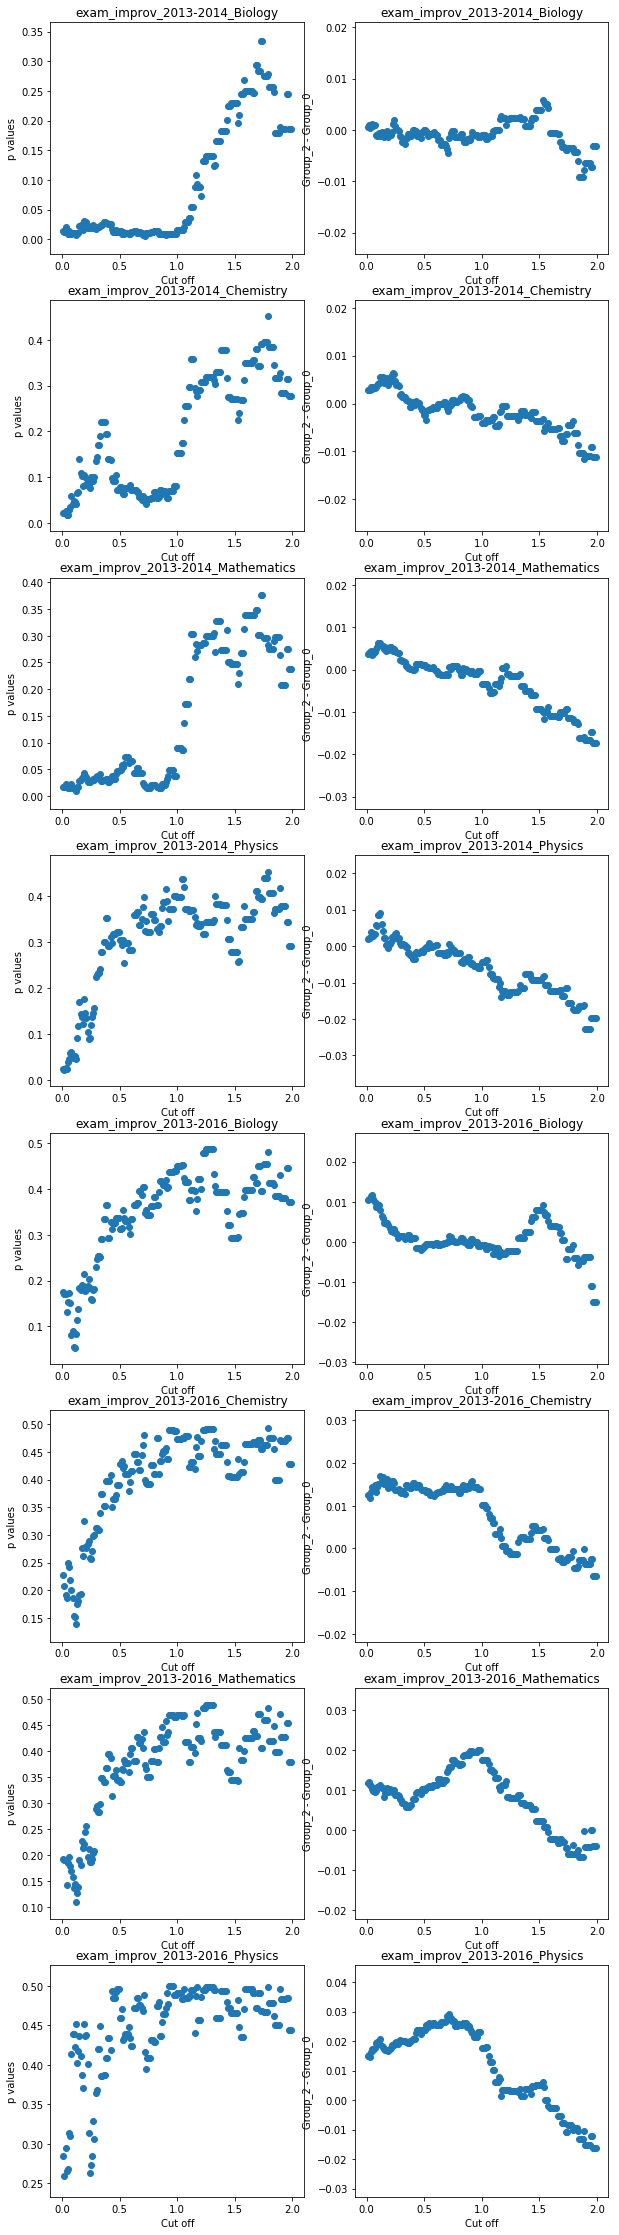

In [103]:
# With a Mann-Whitney U test

bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,200))*0.01
df_score = stat.sensitivity_on_bin(df, 'std_ratio', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], 
                                   cut_off_array, test_type=mannwhitneyu)

stat.plot_sensitivity(df_score,np.unique(df_score['Key']),['p values', 'Group_2 - Group_0'])